
### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2020 Semester 1

## Assignment 1: Naive Bayes Classifiers

###### Submission deadline: 7 pm, Monday 20 Apr 2020

**Student Name(s):**    `Andrew Thomas Liongosari, Kartika Waluyo`

**Student ID(s):**     `954475, 1000555`


This iPython notebook is a template which you will use for your Assignment 1 submission.

Marking will be applied on the four functions that are defined in this notebook, and to your responses to the questions at the end of this notebook (Submitted in a separate PDF file).

**NOTE: YOU SHOULD ADD YOUR RESULTS, DIAGRAMS AND IMAGES FROM YOUR OBSERVATIONS IN THIS FILE TO YOUR REPORT (the PDF file).**

You may change the prototypes of these functions, and you may write other functions, according to your requirements. We would appreciate it if the required functions were prominent/easy to find.

**Adding proper comments to your code is MANDATORY. **

<h3>Libraries to be imported</h3>

In [1]:
import numpy as np
from math import pi, e, sqrt, log
from collections import defaultdict, Counter
import random
import pandas as pd
from sklearn.preprocessing import KBinsDiscretizer
import matplotlib.pyplot as plt

<h3>Small functions to assist later code </h3>

In [2]:
def replace(list_to_work, values_to_replace, val_replacement):
    """
    Replace all occurrences of elements of values_to_replace in list_to_work, by val_replacement

    Arguments: 
    list_to_work: A list containing elements, some of which we would like to replace
    values_to_replace: A list containing elements we would like to replace
    val_replacement: The value with which we would like to replace it by
    """
    
    newlist = []
    #Iterate through list_to_work. If the element is in values_to_replace, add val_replacement to newlist,
    #otherwise add the original element
    for i in list_to_work:
        if i in values_to_replace:
            newlist.append(val_replacement)
        else:
            newlist.append(i)
            
    return newlist

In [3]:
def log_normal_pdf(x, mu, sigma):
    """Returns the value of the normal pdf
    
    Arguments:
    x: The value at which we would like to evaluate the normal pdf
    mu: The mean of the normal distribution
    sigma: The standard deviation of the normal distribution"""
    
    return (log(1/(sigma*sqrt(2*pi))) + ((-0.5* ((x-mu)/sigma)**2)))

<h3>Pre-processing the data</h3>

In [4]:
def preprocess(filename, class_column, train_proportion, ID=False, discretise_numeric_dataset=False, n_bins=None):
    """
    Read the data from a file and split it into training and testing sets
    
    Arguments:
    filename: A string of the file name containing data we want to process
    class_column: An integer indicating the index of class column. Note: If the class column is the 9th column, the index 
    is 8, so enter 8 here.
    train_proportion: The proportion of the dataset to use as the training set. Must be a number between 0 and 1. 
    ID: A boolean, indicating whether the dataset has an ID column. If True, the ID is assumed to be the first column
    (this is true for all of the datasets tested)
    discretise_numeric_dataset: A boolean, indicating whether numeric datasets should be discretised. If 
    the dataset is discrete, ordinal, or mixed (i.e. not completely numeric), this MUST be False.
    n_bins: An integer (if used), which indicates the number of bins used for discretisation. This is ignored unless
    discretise_numeric_dataset is True.
    
    Returns:
    A 4-tuple: (X_train, X_test, y_train, y_test), as NumPy arrays.
    If train_proportion==1, the training set is also the testing set, so X_train and X_test are identical, and 
    y_train and y_test are also identical.
    """
    
    #To make sure that the train-test split is reproducible and consistent across runs.
    #DO NOT CHANGE. CHANGING THIS WILL CHANGE THE TRAIN TEST SPLITS AND MAY CAUSE RESULTS INCONSISTENT WITH OUR ANALYSIS.
    #Our analysis is based on random seed=1
    random.seed(1)
    
    #Record what values should be considered as missing values
    MISSING_VALUES = ["?", ""]
    if filename == "university.data":
        MISSING_VALUES = ["0"]
        
    """ACADEMIC HONESTY DICLAIMER:
    The following section is heavily inspired by the code in Practical Week 3, which we then modified and added onto.
    We do NOT claim to have thought of these lines of code on our own, and it is NOT our original work."""
    
    #Read the data file and put all the data into a 2-D array
    f = open(filename,'r')
    array = []
        
    for line in f:
        #Replacing missing values with None
        #Insert the rows at random points in the list to obtain randomness 
        if len(line.strip().split(","))>1:
            array.insert(random.randint(0, len(array)), replace(line.strip().split(","), MISSING_VALUES, None))
    """END OF SECTION HEAVILY INSPIRED BY THE CODE IN PRACTICAL WEEK 3"""
    
    array = np.array(array)
    
    #Obtain the class labels
    y = [row[class_column] for row in array]

    #Obtain the explanatory variables
    list_of_columns_in_x = [i for i in range(0, len(array[0])) if i != class_column]
    x = [row[list_of_columns_in_x] for row in array]
    
    #If there is an ID column, remove it (assume it is the first column)
    if ID:
        df=pd.DataFrame(x)
        df=df[df.columns[1:]]
        x=df.values

    #Split the dataset into a training set and a testing set. 
    #The first len(x) * train_proportion instances becomes the training set
    
    X_train = x[0:round(len(x) * train_proportion)]
    X_test = x[round(len(x) * train_proportion):len(x)]

    y_train = y[0:round(len(y) * train_proportion)]
    y_test = y[round(len(y) * train_proportion):len(y)]
    
    #If the train proportion is 1, we return X_train as the test set too
    if train_proportion == 1:
        if discretise_numeric_dataset:
            #Discretise the dataset using a separate function
            assert(n_bins is not None)
            X_train, X_train = discretise(X_train, X_train, n_bins)
        return (X_train, X_train, y_train, y_train)
    
    if discretise_numeric_dataset:
        #Discretise the dataset using a separate function
        assert(n_bins is not None)
        X_train, X_test = discretise(X_train, X_test, n_bins)
        
    return (X_train, X_test, y_train, y_test)
                

<h3>Calculating the priors</h3>

In [5]:
def calculate_priors(y_train):
    """
    Calculates the prior probabilities from the training set.
    
    Arguments:
    y_train: An array of class labels
    
    Returns:
    Dictionary of prior probabilities
    """
    prior_dict = {}
    for class_label in dict(Counter(y_train)).keys():
        #Calculate the prior probability of each class label
        prior_dict[class_label] = dict(Counter(y_train))[class_label] / len(y_train)
        
    return prior_dict.copy()

<h3>Training the data</h3>

In [6]:
def train(X_train, y_train, dataset_type, k=1, attr_type_array=None):
    """
    Function to train the naive bayes model.
    
    Inputs:
    X_train: A 2-D array containing feature values for the training set
    y_train: An array of class labels for the training set
    dataset_type: A string. Indicates the data type of the dataset. It must be one of 
    'discrete', 'ordinal', 'continuous', or 'mixed'.
    k: The constant used for Laplace smoothing. Can be any positive real number. Using 0 as k will result in an error
    due to the implementation as log probabilities are used and log 0 is undefined.
    attr_type_array: An array. This needs to be provided if and only if the dataset_type is mixed. 
    This will indicate the attribute type of each attribute in the dataset. 
    0 means 'discrete'
    1 means 'ordinal'
    2 means 'continuous'
    [0, 0, 1, 2] means the first 2 columns are discrete, the second one is ordinal, the third one is continuous
    This indicates the data types for the FEATURES ONLY; exclude the data type for the ID (if any) and class label
    
    Returns: 
    A 2-tuple, which together represents the trained Naive Bayes model.
    The first element is a dictionary, indicating the prior probabilities of each class.
    
    The second element is a complicated dictionary, which contains the conditional probabilities and the mu/sigma pairs.
    The keys of this dictionary are the class labels. The values are another dictionary. 
    Inside THAT dictionary, the keys are the column names/numbers. The values are another dictionary if the column is 
    discrete or ordinal (containing the attribute levels and their conditional probabilities), or a list of 2 elements
    if the column is numeric (containing the mu-sigma pair for that column and class label).
    """
    
    #Ensure validity of dataset_type
    assert(dataset_type in ["Discrete", "Ordinal", "Continuous", "Mixed"])
    if dataset_type == "Mixed":
        assert(attr_type_array is not None)
    
    #Create appropriate attr_type_array if the dataset type is not mixed
    if attr_type_array is None:
        if dataset_type == "Discrete":
            attr_type_array = [0 for i in range(len(X_train[0]))]   #All attributes are discrete
        if dataset_type == "Ordinal":
            attr_type_array = [1 for i in range(len(X_train[0]))]   #All attributes are ordinal
        if dataset_type == "Continuous":
            attr_type_array = [2 for i in range(len(X_train[0]))]   #All attributes are continuous
    
    #Assert validity of attr_type_array
    assert(len(attr_type_array) == len(X_train[0]))
    
    #Get priors
    priors_dict = calculate_priors(y_train)
    
    #Set up data structure
    df = pd.DataFrame(X_train)
    df["y"] = y_train
    
    counts_dict = {}
    for class_label in dict(Counter(y_train)).keys():
        #Create a dictionary with class labels as keys, and dictionaries as values
        counts_dict[class_label] = {}
        
        for i in range(len(X_train[0])):
            #Get counts of classes if the type of attribute is discrete or ordinal
            #We have decided to treat ordinal attributes as discrete
            if attr_type_array[i] == 0 or attr_type_array[i] == 1:
                counts_dict[class_label]["Col" + str(i)] = defaultdict(lambda:k)   #Do Laplace smoothing
                #Filter the DataFrame to get the counts 
                df_filtered = df[df["y"] == class_label]
                counts = dict(Counter(df_filtered[i].values))
                
                #Add the counts to our default dict (for smoothing) if it is not a missing value
                for key in counts:
                    if key is not None:
                        counts_dict[class_label]["Col" + str(i)][key]   #To initialise the value to the Laplace smoothing constant
                        counts_dict[class_label]["Col" + str(i)][key] += counts[key]
                        
                #At this point we have all the real counts, need to do Laplace smoothing to attribute levels that did not occur in a class.
                #First, gather all of the attribute levels
                attribute_levels = set()
                for class_label in counts_dict.keys():
                    for elem in counts_dict[class_label]["Col" + str(i)].keys():
                        attribute_levels.add(elem)
                        
                #If there are no instances of the class with a certain attribute level, put the count of that pair attribute-class as k
                for attribute_level in attribute_levels:
                    for class_label in counts_dict.keys():
                        if attribute_level not in counts_dict[class_label]["Col" + str(i)].keys():
                            counts_dict[class_label]["Col" + str(i)][attribute_level]    #This puts the value as k due to the defaultdict
                
    for class_label in dict(Counter(y_train)).keys():
        #From the smoothed counts, calculate the likelihood of every attribute level in the specific column given the class
        for i in range(len(X_train[0])):
            if attr_type_array[i] == 0 or attr_type_array[i] == 1:     #No need to convert to likelihood if it is numeric
                #Get the necessary data structures
                class_dict = counts_dict[class_label]
                column_dict = class_dict["Col" + str(i)]
                
                #Get and record the sum. We will divide by this number
                counts_dict[class_label]["Col" + str(i)]["sum"] = sum(counts_dict[class_label]["Col" + str(i)].values())
                for attribute_level in column_dict.keys():
                    if attribute_level is not None:
                        #Do the division by the sum
                        counts_dict[class_label]["Col" + str(i)][attribute_level] /= counts_dict[class_label]["Col" + str(i)]["sum"]
                #Delete the (divided) sum so that the probabilities add up to 1
                del counts_dict[class_label]["Col" + str(i)]["sum"] 
                        
            #Get the mean and standard deviation of the attribute in each class if the type of attribute is continuous    
            if attr_type_array[i] == 2:
                #Get the necessary part of the dataset
                attribute = df[i]
                attribute_filtered = attribute[df['y'] == class_label]
                
                #Calculate the mean and standard deviation
                mean = attribute_filtered.astype(float).mean()
                sd = attribute_filtered.astype(float).std()
                
                #Store the calculated mean and standard deviation in counts_dict. Technically, this is now likelihoods_dict 
                #(it is not counts anymore)
                counts_dict[class_label]["Col" + str(i)] = [mean, sd]
                
    return priors_dict, counts_dict    

<h3>Predicting test instances</h3>

In [7]:
def predict(model, X_test):
    """Uses the model (which is the output of train()) to generate predictions for X_test.
    
    Arguments: 
    model: A 2-tuple of dictionaries. The first element of this tuple is the priors dictionary, and
    the second element is the calculated conditional probabilities/mean-sd pairs. This should be the output of train().
    
    X_test: A 2-D array containing test instances. We will get predictions for these test instances.
    
    Returns:
    An array of predicted class labels
    """
    #Get the priors and likelihoods separately
    priors_dict, likelihoods_dict=model
    
    #Set up the predictions array
    predictions=[]
    
    #Now, one by one, calculate the relative probabilities and compare them
    for instance in X_test:
        
        #Initialise with the prior. Take the natural log to avoid underflow.
        predicted_probabilities=priors_dict.copy()
        for class_label in predicted_probabilities.keys():
            predicted_probabilities[class_label]=log(predicted_probabilities[class_label])
        
        #For each attribute, we need to get the pdf value or the conditional probability, take its log, and add it
        #This needs to be done for each class label so that we can compare their results
        for i in range(len(instance)):
            attribute_value = instance[i]
            
            if attribute_value is not None:
                for class_label in predicted_probabilities.keys():
                    #If it is continuous, we calculated the mean and std dev in a tuple and we need to get the PDF value
                    if type(likelihoods_dict[class_label]["Col" + str(i)]) == list:

                        #Attribute values were stored as strings, so we need to convert to float to get the PDF value properly
                        attribute_value=float(attribute_value)

                        #Extract the parameters of the normal distribution
                        mu, sigma=likelihoods_dict[class_label]["Col" + str(i)]

                        #Get the PDF value, take the log, and add it.
                        predicted_probabilities[class_label] += log_normal_pdf(attribute_value, mu, sigma)

                    else:
                        #If it is discrete, we did not store it in a tuple. So, we take the conditional probability, take its log,
                        #and add it
                        predicted_probabilities[class_label] += log(likelihoods_dict[class_label]["Col" + str(i)][attribute_value])
        
        #We have some value class_label from the previous loop. Use it to initialise what is the highest (log) probability
        #value we have found so far, and record what class label that value corresponds to.
        highest_probability = predicted_probabilities[class_label]
        predicted_class = class_label
        
        #Iterate through all the class labels and see if they have a higher probability value.
        #If so, record that value and what class label that value corresponds to.
        #The class label with the highest (log) probability value becomes our predicted class
        for class_label in predicted_probabilities.keys():
            if predicted_probabilities[class_label] > highest_probability:
                highest_probability = predicted_probabilities[class_label]
                predicted_class = class_label
                
        #Add the predicted class to our predictions
        predictions.append(predicted_class)
            
    return predictions                

<h3>Evaluating the model</h3>

In [8]:
def evaluate(y_pred, y_true):
    """Returns the accuracy of predictions. Inputs are the predicted and true class labels, in array-like form"""
    
    return sum(pd.Series(y_pred) == pd.Series(y_true)) / len(y_true)

<h3>Running the classifier with various settings to get data for the report</h3>

### Q1
Try discretising the numeric attributes in these datasets and treating them as discrete variables in the na¨ıve Bayes classifier. You can use a discretisation method of your choice and group the numeric values into any number of levels (but around 3 to 5 levels would probably be a good starting point). Does discretizing the variables improve classification performance, compared to the Gaussian na¨ıve Bayes approach? Why or why not?

<h3>Implementation required for questions</h3>

In [9]:
def discretise(X_train, X_test, n_bins=5):
    """
    Function to convert a continuous dataset into a discrete dataset
    
    Inputs:
    X_train: A 2-D array containing feature values for the training instances.
    X_test: A 2-D array containing test instances. 
    n_bins: Number of bins we want to discretise our data into
        
    Returns: A 2-tuple, containing the discretised X_train and discretised X_test
    """
    
    #Instantiate the discretiser
    discretiser = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')
    
    #Convert the X_train and X_test into the type required by the discretiser
    X_train = np.array(X_train).astype(float)
    X_test = np.array(X_test).astype(float)
    
    #Fit the discretiser with X_train
    discretiser.fit(X_train)
    
    #Transform both X_train and X_test
    X_train = discretiser.transform(X_train).astype(int)
    X_test  = discretiser.transform(X_test).astype(int)
    
    return X_train, X_test

<h3>Compare the performance of the Naive Bayes classifier on a continuous dataset and discretised continuous datasets</h3>

<h4>WDBC dataset: Not discretised, then discretised with various number of bins</h4>

In [10]:
#Note that we use a train-test split of 80/20 in this question, so results will be different to testing on the training set
#Try the undiscretised dataset first.
#Preprocess
(X_train, X_test, y_train, y_test) = preprocess(filename="wdbc.data", class_column=1, train_proportion=0.8, 
                                                ID=True, discretise_numeric_dataset=False, n_bins=None)
#Train the model
model=train(X_train, y_train, "Continuous", k=1)

#Generate predictions
predictions=predict(model, X_test)

#Record the number of bins tried and the resulting accuracy
bins_tried=[0]
accuracies=[evaluate(predictions, y_test)]

#Try discretised datasets, with various number of bins
for n_bins in range(2, 20, 3):
    #Preprocess
    (X_train, X_test, y_train, y_test) = preprocess(filename="wdbc.data", class_column=1, train_proportion=0.8, 
                                                    ID=True, discretise_numeric_dataset=True, n_bins=n_bins)
    
    #Train
    model=train(X_train, y_train, "Discrete", k=1)
    
    #Predict
    predictions=predict(model, X_test)
    
    #Evaluate
    accuracy = evaluate(predictions, y_test)
    
    #Record the number of bins tried and the resulting accuracy
    bins_tried.append(n_bins)
    accuracies.append(accuracy)
    
#Create a DataFrame containing the results
df=pd.DataFrame([])
df["n_bins"]=bins_tried
df["accuracy"]=accuracies

#Show the results
df

,n_bins,accuracy
0,0,0.921053
1,2,0.903509
2,5,0.947368
3,8,0.956140
4,11,0.947368
5,14,0.929825
6,17,0.929825


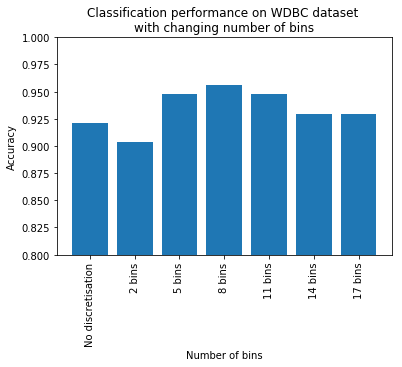

In [11]:
#Plot the results
plt.bar(range(len(df)), df["accuracy"], tick_label=["No discretisation", "2 bins", "5 bins", "8 bins", 
                                                    "11 bins", "14 bins", "17 bins"])

#Create the chart elements
plt.xticks(rotation = 90)
plt.ylim([0.8, 1])
plt.title("Classification performance on WDBC dataset \nwith changing number of bins")
plt.ylabel("Accuracy")
plt.xlabel("Number of bins")
plt.show()

<h4>Wine dataset: Not discretised, then discretised with various number of bins</h4>

In [12]:
#Try the undiscretised dataset first.
#Preprocess
(X_train, X_test, y_train, y_test) = preprocess(filename="wine.data", class_column=0, train_proportion=0.8, 
                                                ID=False, discretise_numeric_dataset=False, n_bins=None)

#Train the model
model=train(X_train, y_train, "Continuous", k=1)

#Generate predictions
predictions=predict(model, X_test)

#Record the number of bins tried and the resulting accuracy
bins_tried=[0]
accuracies=[evaluate(predictions, y_test)]

#Try discretised datasets, with various number of bins
for n_bins in range(2, 20, 3):
    #Preprocess
    (X_train, X_test, y_train, y_test) = preprocess(filename="wine.data", class_column=0, train_proportion=0.8, 
                                                    ID=False, discretise_numeric_dataset=True, n_bins=n_bins)
    
    #Train the model
    model=train(X_train, y_train, "Discrete", k=1)
    
    #Generate predictions
    predictions=predict(model, X_test)
    
    #Evaluate
    accuracy = evaluate(predictions, y_test)
    
    #Record the number of bins tried and the resulting accuracy
    bins_tried.append(n_bins)
    accuracies.append(accuracy)
    
#Create a DataFrame containing the results
df=pd.DataFrame([])
df["n_bins"]=bins_tried
df["accuracy"]=accuracies

#Show the results
df

,n_bins,accuracy
0,0,0.972222
1,2,0.944444
2,5,0.972222
3,8,1.000000
4,11,0.944444
5,14,0.944444
6,17,0.944444


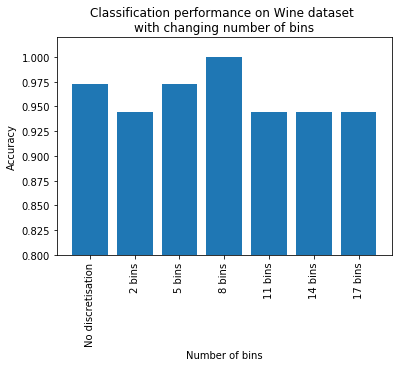

In [13]:
#Plot the results
plt.bar(range(len(df)), df["accuracy"], tick_label=["No discretisation", "2 bins", "5 bins", "8 bins", 
                                                    "11 bins", "14 bins", "17 bins"])

#Create the chart elements
plt.xticks(rotation = 90)
plt.ylim([0.8, 1.02])
plt.title("Classification performance on Wine dataset \nwith changing number of bins")
plt.ylabel("Accuracy")
plt.xlabel("Number of bins")
plt.show()

### Q2
Implement a baseline model (e.g., random or 0R) and compare the performance of the na¨ıve Bayes classifier to this baseline on multiple datasets. Discuss why the baseline performance varies across datasets, and to what extent the na¨ıve Bayes classifier improves on the baseline performance.

<h3>Implementation required for questions</h3>

In [14]:
def zero_r_train(y_train):
    """
    Counts the class label occurences in y_train and returns the most common class. 
    This is technically the "model" for 0-R, as subsequent predictions simply predict this class.
    
    Arguments:
    y_train: An array of class labels in the training set
    
    Returns:
    A string, indicating the most common class
    """
    #Get counts
    y_counts = dict(Counter(y_train))
    
    #Find the class with the highest count
    most_common_class = list(y_counts.keys())[np.argmax(list(y_counts.values()))]
    
    return most_common_class

def zero_r_predict(zero_r_model, X_test):
    """
    Returns the prediction of the zero-R model for each instance in X_test, which is simply the most common class label in 
    the training set
    
    Arguments:
    zero_r_model: A string, indicating the most common class label in the training set. This is the zero-R "model"
    X_test: A 2-D array, containing the instances we would like to predict the class labels for.
    """
    
    return [zero_r_model for i in X_test]

<h3>Compare the performance of 0-R and naive Bayes classifier</h3>

In [15]:
zero_r_bayes_acc_df = pd.DataFrame()
bayes = []
zero_r = []
dataset = []

In [16]:
#Try on a continuous dataset with 2 classes: WDBC
#Note that we use a train-test split of 80/20 in this question, so results will be different to testing on the training set
#Preprocess the dataset, train the model, and generate predictions
(X_train, X_test, y_train, y_test) = preprocess(filename="wdbc.data", class_column=1, train_proportion=0.8, 
                                                ID=True, discretise_numeric_dataset=False, n_bins=None)
model=train(X_train, y_train, "Continuous", k=1)
predictions=predict(model, X_test)

#Find and record the accuracy of the Naive Bayes model
bayes.append(evaluate(predictions, y_test))

#Train the zero-R classifier, generate its predictions, and find and record its accuracy
zero_r_model = zero_r_train(y_train)
zero_r_prediction = zero_r_predict(zero_r_model, X_test)
zero_r.append(evaluate(zero_r_prediction, y_test))

#Record the dataset used
dataset.append("Wdbc")

In [17]:
#Try on a mixed-type dataset with 2 classes: Adult

#Preprocess the dataset, train the model, and generate predictions
(X_train, X_test, y_train, y_test) = preprocess(filename="adult.data", class_column=14, train_proportion=0.8, 
                                                ID=False, discretise_numeric_dataset=False, n_bins=None)
model=train(X_train, y_train, "Mixed", k=1, attr_type_array=[2, 0, 2, 1, 1, 0, 0, 0, 0, 0, 2, 2, 2, 0])
predictions=predict(model, X_test)

#Find and record the accuracy of the Naive Bayes model
bayes.append(evaluate(predictions, y_test))

#Train the zero-R classifier, generate its predictions, and find and record its accuracy
zero_r_model = zero_r_train(y_train)
zero_r_prediction = zero_r_predict(zero_r_model, X_test)
zero_r.append(evaluate(zero_r_prediction, y_test))

#Record the dataset used
dataset.append("Adult")

In [18]:
#Try on a discrete dataset with 2 classes: Breast Cancer Wisconsin

#Preprocess the dataset, train the model, and generate predictions
(X_train, X_test, y_train, y_test) = preprocess(filename="breast-cancer-wisconsin.data", class_column=10, train_proportion=0.8, 
                                                ID=True, discretise_numeric_dataset=False, n_bins=None)
model=train(X_train, y_train, "Discrete", k=1)
predictions=predict(model, X_test)

#Find and record the accuracy of the Naive Bayes model
bayes.append(evaluate(predictions, y_test))

#Train the zero-R classifier, generate its predictions, and find and record its accuracy
zero_r_model = zero_r_train(y_train)
zero_r_prediction = zero_r_predict(zero_r_model, X_test)
zero_r.append(evaluate(zero_r_prediction, y_test))

#Record the dataset used
dataset.append("Breast Cancer Wisconsin")

In [19]:
#Try on a discrete dataset with many classes: Lymphography

#Preprocess the dataset, train the model, and generate predictions
(X_train, X_test, y_train, y_test) = preprocess(filename="lymphography.data", class_column=0, train_proportion=0.8, 
                                                ID=False, discretise_numeric_dataset=False, n_bins=None)
model=train(X_train, y_train, "Discrete", k=1)
predictions=predict(model, X_test)

#Find and record the accuracy of the Naive Bayes model
bayes.append(evaluate(predictions, y_test))

#Train the zero-R classifier, generate its predictions, and find and record its accuracy
zero_r_model = zero_r_train(y_train)
zero_r_prediction = zero_r_predict(zero_r_model, X_test)
zero_r.append(evaluate(zero_r_prediction, y_test))

#Record the dataset used
dataset.append("Lymphography")

In [20]:
#Try on a continuous dataset with many classes: Wine

#Preprocess the dataset, train the model, and generate predictions
(X_train, X_test, y_train, y_test) = preprocess(filename="wine.data", class_column=0, train_proportion=0.8, 
                                                ID=False, discretise_numeric_dataset=False, n_bins=None)
model=train(X_train, y_train, "Continuous", k=1)
predictions=predict(model, X_test)

#Find and record the accuracy of the Naive Bayes model
bayes.append(evaluate(predictions, y_test))

#Train the zero-R classifier, generate its predictions, and find and record its accuracy
zero_r_model = zero_r_train(y_train)
zero_r_prediction = zero_r_predict(zero_r_model, X_test)
zero_r.append(evaluate(zero_r_prediction, y_test))

#Record the dataset used
dataset.append("Wine")

In [21]:
#Try on a mixed-type dataset with many classes:  University

#Preprocess the dataset, train the model, and generate predictions
(X_train, X_test, y_train, y_test) = preprocess(filename="university.data", class_column=14, train_proportion=0.8, 
                                                ID=True, discretise_numeric_dataset=False, n_bins=None)
model=train(X_train, y_train, "Mixed", k=1, attr_type_array=[0, 0, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 1, 0])
predictions=predict(model, X_test)

#Find and record the accuracy of the Naive Bayes model
bayes.append(evaluate(predictions, y_test))

#Train the zero-R classifier, generate its predictions, and find and record its accuracy
zero_r_model = zero_r_train(y_train)
zero_r_prediction = zero_r_predict(zero_r_model, X_test)
zero_r.append(evaluate(zero_r_prediction, y_test))

#Record the dataset used
dataset.append("University")

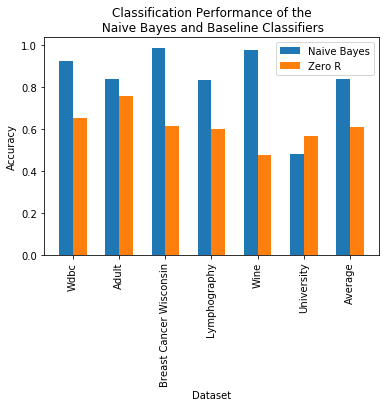

In [22]:
#Find and record the average accuracy for both the Naive Bayes and 0-R classifiers
dataset.append("Average")
bayes.append(pd.Series(bayes).mean())
zero_r.append(pd.Series(zero_r).mean())

#Convert the lists into a DataFrame for easy viewing
zero_r_bayes_acc_df=pd.DataFrame()
zero_r_bayes_acc_df['Dataset'] = dataset
zero_r_bayes_acc_df['Bayes'] = bayes
zero_r_bayes_acc_df['Zero R'] = zero_r

#Draw a bar graph of the accuracies of Naive Bayes and 0-R classifiers across different datasets
plt.bar([i-0.15 for i in range(len(zero_r_bayes_acc_df))], zero_r_bayes_acc_df["Bayes"].values, width = 0.3)
plt.bar([i+0.15 for i in range(len(zero_r_bayes_acc_df))], zero_r_bayes_acc_df["Zero R"].values, width = 0.3)

#Create the chart elements
plt.legend(["Naive Bayes", "Zero R"])
plt.xticks(list(range(len(zero_r_bayes_acc_df))), zero_r_bayes_acc_df['Dataset'], rotation = 90)
plt.ylabel("Accuracy")
plt.xlabel("Dataset")
plt.title("Classification Performance of the\n Naive Bayes and Baseline Classifiers")
plt.show()


In [23]:
#Simply show the table containing the accuracies of the Naive Bayes and Zero-R classifiers
zero_r_bayes_acc_df

,Dataset,Bayes,Zero R
0,Wdbc,0.921053,0.649123
1,Adult,0.834613,0.756757
2,Breast Cancer Wisconsin,0.985714,0.614286
3,Lymphography,0.833333,0.600000
4,Wine,0.972222,0.472222
5,University,0.478261,0.565217
6,Average,0.837533,0.609601


### Q4
Evaluating the model on the same data that we use to train the model is considered to be a major mistake in Machine Learning. Implement a hold–out or cross–validation evaluation strategy (you should implement this yourself and do not simply call existing implementations from `scikit-learn`). How does your estimate of effectiveness change, compared to testing on the training data? Explain why. (The result might surprise you!)

<h3>Compare the classifier's accuracies for different train/test splits</h3>

In [24]:
#Prepare data structures for later use
proportion_accuracy_df = pd.DataFrame()
datasets = []
proportions_list = []
accuracies = []

In [25]:
proportions = [1, 0.8, 0.5, 0.01]

#Try on a continuous dataset with 2 classes: WDBC
dataset = "Wdbc"

for train_proportion in proportions:
    
    #Preprocess the dataset, train the model, create predictions, and find the accuracy, then record results
    (X_train, X_test, y_train, y_test) = preprocess(filename="wdbc.data", class_column=1, train_proportion=train_proportion, 
                                                ID=True, discretise_numeric_dataset=False, n_bins=None)
    model=train(X_train, y_train, "Continuous", k=1)
    predictions=predict(model, X_test)    
    proportions_list.append(train_proportion)
    accuracies.append(evaluate(predictions, y_test))
    datasets.append(dataset)

In [26]:
#Try on a continuous dataset with many classes: Wine

dataset = "Wine"
for train_proportion in proportions:
    
    #Preprocess the dataset, train the model, create predictions, and find the accuracy, then record results
    (X_train, X_test, y_train, y_test) = preprocess(filename="wine.data", class_column=0, train_proportion=train_proportion, 
                                                ID=False, discretise_numeric_dataset=False, n_bins=None)
    model=train(X_train, y_train, "Continuous", k=1)
    predictions=predict(model, X_test)
    proportions_list.append(train_proportion)
    accuracies.append(evaluate(predictions, y_test))
    datasets.append(dataset)

In [27]:
#Try on a mixed-type dataset with many classes: University

dataset = "University"
for train_proportion in proportions:
    
    #Preprocess the dataset, train the model, create predictions, and find the accuracy, then record results
    (X_train, X_test, y_train, y_test) = preprocess(filename="university.data", class_column=14, train_proportion=train_proportion, 
                                                    ID=True, discretise_numeric_dataset=False, n_bins=None)
    model=train(X_train, y_train, "Mixed", k=1, attr_type_array=[0, 0, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 1, 0])
    predictions=predict(model, X_test)
    accuracies.append(evaluate(predictions, y_test))
    proportions_list.append(train_proportion)
    datasets.append(dataset)

In [28]:
#Try on an ordinal dataset with many classes: Car

dataset = "Car"
for train_proportion in proportions:
    
    #Preprocess the dataset, train the model, create predictions, and find the accuracy, then record results
    (X_train, X_test, y_train, y_test) = preprocess(filename="car.data", class_column=6, train_proportion=train_proportion, 
                                                ID=False, discretise_numeric_dataset=False, n_bins=None)
    model=train(X_train, y_train, "Ordinal", k=1)
    predictions=predict(model, X_test)
    proportions_list.append(train_proportion)
    accuracies.append(evaluate(predictions, y_test))
    datasets.append(dataset)

In [29]:
#Try on a discrete dataset with many classes: Lymphography

dataset = "Lymphography"
for train_proportion in proportions:
    #Preprocess the dataset, train the model, create predictions, and find the accuracy, then record results
    (X_train, X_test, y_train, y_test) = preprocess(filename="lymphography.data", class_column=0, train_proportion=train_proportion, 
                                                ID=False, discretise_numeric_dataset=False, n_bins=None)
    model=train(X_train, y_train, "Discrete", k=1)
    predictions=predict(model, X_test)
    proportions_list.append(train_proportion)
    accuracies.append(evaluate(predictions, y_test))
    datasets.append(dataset)

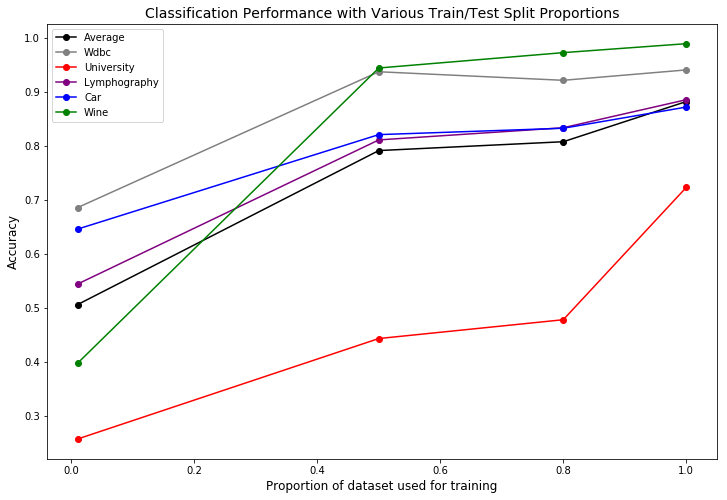

In [30]:
#Populate the dataframe for plotting
proportion_accuracy_df['Dataset'] = datasets
proportion_accuracy_df['Proportion'] = proportions_list
proportion_accuracy_df['Accuracy'] = accuracies

#Calculate and record the average accuracy of the classifier in each proportion
df_average=proportion_accuracy_df.groupby(by='Proportion').mean().reset_index()
df_average["Dataset"]="Average"
df_average=df_average[["Dataset", "Proportion", "Accuracy"]]

#Combine df_average with proportion_accuracy_df
proportion_accuracy_df=pd.concat([proportion_accuracy_df, df_average])

#Prepare for drawing the chart of results
plt.figure(figsize=(12, 8))
colours=["black", "0.5", "red", "purple", "blue", "green"]
colour_index=0

#Iteratively plot the results for each dataset
for dataset in set(proportion_accuracy_df["Dataset"].values):
    
    #Get the section of proportion_accuracy_df that corresponds to the current dataset
    active_df=proportion_accuracy_df[proportion_accuracy_df["Dataset"]==dataset].copy()
    
    #Plot results, and increment colour_index so that a different colour is used next time
    plt.plot(active_df["Proportion"], active_df["Accuracy"], color=colours[colour_index], marker='o', 
             markerfacecolor=colours[colour_index], markersize='6')
    colour_index+=1
    
#Create the chart elements
plt.legend(set(proportion_accuracy_df["Dataset"].values))
plt.xlabel("Proportion of dataset used for training", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Classification Performance with Various Train/Test Split Proportions", fontsize=14)
plt.show()

In [31]:
#Show the results as a table
proportion_accuracy_df

,Dataset,Proportion,Accuracy
0,Wdbc,1.00,0.940246
1,Wdbc,0.80,0.921053
2,Wdbc,0.50,0.936842
3,Wdbc,0.01,0.685613
4,Wine,1.00,0.988764
5,Wine,0.80,0.972222
6,Wine,0.50,0.943820
7,Wine,0.01,0.397727
8,University,1.00,0.722944
9,University,0.80,0.478261


### Q5
Implement one of the advanced smoothing regimes (add-k, Good-Turing). Does changing the smoothing regime (or indeed, not smoothing at all) affect the effectiveness of the na¨ıve Bayes classifier? Explain why, or why not.

<h3>Compare the effectiveness of the naive Bayes classifier with different k-values on add-k smoothing regime</h3>

In [32]:
#Prepare data structures
k_accuracy_df = pd.DataFrame()
k_value_list = []
accuracies = []
datasets = []

In [33]:
#Note that we use a train-test split of 80/20 in this question, so results will be different to testing on the training set

k_values = [0.000001, 0.5, 0.8, 1, 2, 3, 10, 1000000]
#k=0.000001 simulates unsmoothed Naive Bayes classifier, as k=0 will cause an error

#Try on a discrete dataset with 2 classes: Lymphography
dataset = "Lymphography"

for k in k_values:
    #Preprocess the dataset, train the model, and generate predictions
    (X_train, X_test, y_train, y_test) = preprocess(filename="lymphography.data", class_column=0, train_proportion=0.8, 
                                                ID=False, discretise_numeric_dataset=False, n_bins=None)
    model=train(X_train, y_train, "Discrete", k=k)
    predictions=predict(model, X_test)
    
    #Find the accuracy of the predictions and record the results
    k_value_list.append(k)
    accuracies.append(evaluate(predictions, y_test))
    datasets.append(dataset)

In [34]:
#Try on a discrete dataset with 2 classes: Mushroom
dataset = "Mushroom"

for k in k_values:
    #Preprocess the dataset, train the model, and generate predictions
    (X_train, X_test, y_train, y_test) = preprocess(filename="mushroom.data", class_column=0, train_proportion=0.8, 
                                                    ID=False, discretise_numeric_dataset=False, n_bins=None)
    model=train(X_train, y_train, "Discrete", k=k)
    predictions=predict(model, X_test)
    
    #Find the accuracy of the predictions and record the results
    k_value_list.append(k)
    accuracies.append(evaluate(predictions, y_test))
    datasets.append(dataset)

In [35]:
#Try on an ordinal dataset with 2 classes: Somerville
dataset = "Somerville"

for k in k_values:
    #Preprocess the dataset, train the model, and generate predictions
    (X_train, X_test, y_train, y_test) = preprocess(filename="somerville.data", class_column=0, train_proportion=0.8, 
                                                ID=False, discretise_numeric_dataset=False, n_bins=None)
    model=train(X_train, y_train, "Ordinal", k=k)
    predictions=predict(model, X_test)
    
    #Find the accuracy of the predictions and record the results
    k_value_list.append(k)
    accuracies.append(evaluate(predictions, y_test))
    datasets.append(dataset)

In [36]:
#Try on an ordinal dataset with many classes: Car
dataset = "Car"

for k in k_values:
    #Preprocess the dataset, train the model, and generate predictions
    (X_train, X_test, y_train, y_test) = preprocess(filename="car.data", class_column=6, train_proportion=0.5, 
                                                ID=False, discretise_numeric_dataset=False, n_bins=None)
    model=train(X_train, y_train, "Ordinal", k=k)
    predictions=predict(model, X_test)
    
    #Find the accuracy of the predictions and record the results
    k_value_list.append(k)
    accuracies.append(evaluate(predictions, y_test))
    datasets.append(dataset)

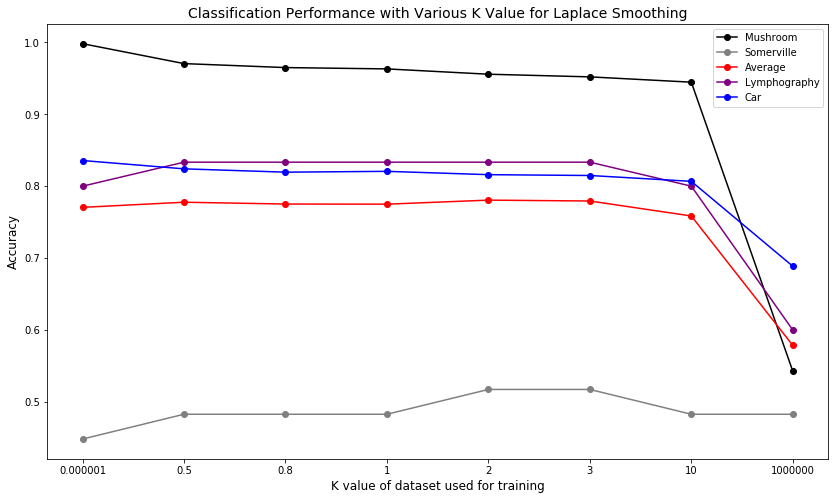

In [37]:
#Populate the dataframe for plotting
k_accuracy_df['Dataset'] = datasets
k_accuracy_df['K Value'] = k_value_list
k_accuracy_df['Accuracy'] = accuracies

#For each k-value, find the average accuracy of the classifier across all tested datasets
df_average=k_accuracy_df.groupby(by='K Value').mean().reset_index()
df_average["Dataset"]="Average"
df_average=df_average[["Dataset", "K Value", "Accuracy"]]

#Combine the average results with the other results
k_accuracy_df=pd.concat([k_accuracy_df, df_average])


#Prepare for plotting a chart
plt.figure(figsize=(14, 8))
colours=["black", "0.5", "red", "purple", "blue", "green"]
colour_index=0

#Iteratively, plot the results for each dataset
for dataset in set(k_accuracy_df["Dataset"].values):
    
    #Get the part of the DataFrame that corresponds to the current dataset
    active_df=k_accuracy_df[k_accuracy_df["Dataset"]==dataset].copy()
    
    #Plot results, and increment colour_index so that a different colour is used next time
    plt.plot(range(8), active_df["Accuracy"], color=colours[colour_index], marker='o', 
             markerfacecolor=colours[colour_index], markersize='6')
    colour_index+=1

#Create the chart elements
plt.legend(set(k_accuracy_df["Dataset"].values))
plt.xlabel("K value of dataset used for training", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Classification Performance with Various K Value for Laplace Smoothing", fontsize=14)
plt.xticks(list(range(8)), ["0.000001", "0.5", "0.8", "1", "2", "3", "10", "1000000"])
plt.show()

In [38]:
#Show results in the form of a table
k_accuracy_df.reset_index()[["Dataset", "K Value", "Accuracy"]]

,Dataset,K Value,Accuracy
0,Lymphography,0.000001,0.800000
1,Lymphography,0.500000,0.833333
2,Lymphography,0.800000,0.833333
3,Lymphography,1.000000,0.833333
4,Lymphography,2.000000,0.833333
5,Lymphography,3.000000,0.833333
6,Lymphography,10.000000,0.800000
7,Lymphography,1000000.000000,0.600000
8,Mushroom,0.000001,0.998154
9,Mushroom,0.500000,0.970462
